In [70]:
import pandas as pd
import numpy as np
from fastprogress.fastprogress import progress_bar 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
import os
import pickle

In [2]:
# get data

data = pd.read_csv('../../Final/analysis/triplicate_batch_VGG19_kmeans40_labels.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data

,cell,drug,min_conc,max_conc,min_norm_intensity,max_norm_intensity,mean_sd,convergence,upper_limit,IC50,slope,lower_limit,file_path,image_name,cluster,label
0,8570,1034,0.007812,2.0,0.074097,0.664380,0.044709,True,0.901533,0.010218,-2.155016,0.152275,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_3.png,12,Mediocre
1,8570,1034,0.007812,2.0,0.087338,0.672330,0.040231,True,1.610422,0.005150,-1.883030,0.167002,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_6.png,12,Mediocre
2,8570,1034,0.007812,2.0,0.068806,0.717342,0.050703,True,14.883637,0.000010,-0.010746,-12.938230,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_9.png,29,Bad
3,8570,1034,0.007812,2.0,0.071687,0.569093,0.038261,True,0.744103,0.011272,-1.882265,0.129222,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_12.png,12,Mediocre
4,8570,1034,0.007812,2.0,0.058225,0.714683,0.055069,True,0.654130,0.026046,-6.163449,0.129686,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_15.png,19,Mediocre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63231,6412,1192,0.009766,10.0,0.307581,1.335618,0.078498,True,1.165328,6.381202,-1.442833,-0.115036,/Users/akfay/Documents/Capstone/triplicate_bat...,HCC2218_1192_347_Glo_2000_4_3.png,38,Mediocre
63232,6413,1192,0.009766,10.0,0.671477,1.099878,0.064007,True,1.042716,22.063667,-0.497382,0.277841,/Users/akfay/Documents/Capstone/triplicate_bat...,AU565_1192_347_Glo_500_4_3.png,37,Mediocre
63233,6290,1192,0.009766,10.0,0.640827,1.023175,0.069889,True,0.911329,0.957016,-9.194456,0.793217,/Users/akfay/Documents/Capstone/triplicate_bat...,HCC1187_1192_347_Glo_3000_4_3.png,1,No Response
63234,6310,1192,0.009766,10.0,0.572646,1.129622,0.119326,True,0.928182,1782.928576,-0.634245,-6.424923,/Users/akfay/Documents/Capstone/triplicate_bat...,MDA-MB-231_1192_347_Glo_100_4_3.png,6,Mediocre


In [3]:
# some image names are duplicated so only keep the first instance

data = data[~data.duplicated('image_name', keep='first')]
data

,cell,drug,min_conc,max_conc,min_norm_intensity,max_norm_intensity,mean_sd,convergence,upper_limit,IC50,slope,lower_limit,file_path,image_name,cluster,label
0,8570,1034,0.007812,2.0,0.074097,0.664380,0.044709,True,0.901533,0.010218,-2.155016,0.152275,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_3.png,12,Mediocre
1,8570,1034,0.007812,2.0,0.087338,0.672330,0.040231,True,1.610422,0.005150,-1.883030,0.167002,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_6.png,12,Mediocre
2,8570,1034,0.007812,2.0,0.068806,0.717342,0.050703,True,14.883637,0.000010,-0.010746,-12.938230,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_9.png,29,Bad
3,8570,1034,0.007812,2.0,0.071687,0.569093,0.038261,True,0.744103,0.011272,-1.882265,0.129222,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_12.png,12,Mediocre
4,8570,1034,0.007812,2.0,0.058225,0.714683,0.055069,True,0.654130,0.026046,-6.163449,0.129686,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_15.png,19,Mediocre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63231,6412,1192,0.009766,10.0,0.307581,1.335618,0.078498,True,1.165328,6.381202,-1.442833,-0.115036,/Users/akfay/Documents/Capstone/triplicate_bat...,HCC2218_1192_347_Glo_2000_4_3.png,38,Mediocre
63232,6413,1192,0.009766,10.0,0.671477,1.099878,0.064007,True,1.042716,22.063667,-0.497382,0.277841,/Users/akfay/Documents/Capstone/triplicate_bat...,AU565_1192_347_Glo_500_4_3.png,37,Mediocre
63233,6290,1192,0.009766,10.0,0.640827,1.023175,0.069889,True,0.911329,0.957016,-9.194456,0.793217,/Users/akfay/Documents/Capstone/triplicate_bat...,HCC1187_1192_347_Glo_3000_4_3.png,1,No Response
63234,6310,1192,0.009766,10.0,0.572646,1.129622,0.119326,True,0.928182,1782.928576,-0.634245,-6.424923,/Users/akfay/Documents/Capstone/triplicate_bat...,MDA-MB-231_1192_347_Glo_100_4_3.png,6,Mediocre


In [25]:
data['label'] = data['label'].str.lower()

/var/folders/nn/zyrgwx2n2kz51m6jgsh64jv00000gn/T/ipykernel_69811/168064834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].str.lower()


In [29]:
# save updated file

if os.path.exists('../analysis') == False:
    os.makedirs('../analysis')

data.to_csv('../analysis/triplicate_batch_VGG19_kmeans40_labels_updated.csv', index=False)

In [30]:
# change convergence column to binary from bool

data['convergence'] = np.where(data['convergence']==True, 1, 0)
data

/var/folders/nn/zyrgwx2n2kz51m6jgsh64jv00000gn/T/ipykernel_69811/1067048804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['convergence'] = np.where(data['convergence']==True, 1, 0)


,cell,drug,min_conc,max_conc,min_norm_intensity,max_norm_intensity,mean_sd,convergence,upper_limit,IC50,slope,lower_limit,file_path,image_name,cluster,label
0,8570,1034,0.007812,2.0,0.074097,0.664380,0.044709,1,0.901533,0.010218,-2.155016,0.152275,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_3.png,12,mediocre
1,8570,1034,0.007812,2.0,0.087338,0.672330,0.040231,1,1.610422,0.005150,-1.883030,0.167002,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_6.png,12,mediocre
2,8570,1034,0.007812,2.0,0.068806,0.717342,0.050703,1,14.883637,0.000010,-0.010746,-12.938230,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_9.png,29,bad
3,8570,1034,0.007812,2.0,0.071687,0.569093,0.038261,1,0.744103,0.011272,-1.882265,0.129222,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_12.png,12,mediocre
4,8570,1034,0.007812,2.0,0.058225,0.714683,0.055069,1,0.654130,0.026046,-6.163449,0.129686,/Users/akfay/Documents/Capstone/triplicate_bat...,PC-14_1034_419_Glo_250_4_15.png,19,mediocre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63231,6412,1192,0.009766,10.0,0.307581,1.335618,0.078498,1,1.165328,6.381202,-1.442833,-0.115036,/Users/akfay/Documents/Capstone/triplicate_bat...,HCC2218_1192_347_Glo_2000_4_3.png,38,mediocre
63232,6413,1192,0.009766,10.0,0.671477,1.099878,0.064007,1,1.042716,22.063667,-0.497382,0.277841,/Users/akfay/Documents/Capstone/triplicate_bat...,AU565_1192_347_Glo_500_4_3.png,37,mediocre
63233,6290,1192,0.009766,10.0,0.640827,1.023175,0.069889,1,0.911329,0.957016,-9.194456,0.793217,/Users/akfay/Documents/Capstone/triplicate_bat...,HCC1187_1192_347_Glo_3000_4_3.png,1,no response
63234,6310,1192,0.009766,10.0,0.572646,1.129622,0.119326,1,0.928182,30.000000,-0.634245,-6.424923,/Users/akfay/Documents/Capstone/triplicate_bat...,MDA-MB-231_1192_347_Glo_100_4_3.png,6,mediocre


In [31]:
# some of the values are extremely large or small, so make new values that do not go over 30 or under 0.0000001

data['IC50'] = data['IC50'].where(data['IC50']<30, 30)
data['IC50'] = data['IC50'].where(data['IC50']>0.0000001, 0)

/var/folders/nn/zyrgwx2n2kz51m6jgsh64jv00000gn/T/ipykernel_69811/1699191477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IC50'] = data['IC50'].where(data['IC50']<30, 30)
/var/folders/nn/zyrgwx2n2kz51m6jgsh64jv00000gn/T/ipykernel_69811/1699191477.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IC50'] = data['IC50'].where(data['IC50']>0.0000001, 0)


In [32]:
# define X and y

X = data.iloc[:,:12]
y = data.iloc[:,-1]

In [33]:
# split into test and train sets

random_state = 1
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

In [34]:
# scale X to compare to unscaled

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)

# define scoring metric

f1 = make_scorer(f1_score, average='weighted')

#### Train Random Forest model using unscaled features

In [158]:
# round 1 of hyperparameter tuning using randomized search cv

n_estimators = [10,50,100,500]
max_depth = [1,5,10,50]
min_samples_split = [2,5]
min_samples_leaf = [1,2,5]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    verbose=1,
    cv=5,
    n_iter=20,
    scoring=f1,
    random_state=0)

rf_random.fit(X_train, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8605853568259313
RandomForestClassifier(max_depth=50, min_samples_split=5)
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50}


In [162]:
# round 2 hyperparamter tuning using grid search cv

n_estimators = [50,100,200]
max_depth = [25,50,100]
min_samples_split = [3,5,7]
min_samples_leaf = [1,2,3]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.8617277034939408
RandomForestClassifier(max_depth=100, min_samples_split=3, n_estimators=200)
{'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


In [163]:
# round 3 of hyperparameter tuning using grid search cv

n_estimators = [175,200,225]
max_depth = [75,100,125]
min_samples_split = [3]
min_samples_leaf = [1]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8623178610170544
RandomForestClassifier(max_depth=75, min_samples_split=3, n_estimators=200)
{'max_depth': 75, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


In [164]:
# round 4 of hyperparameter tuning using grid search cv

n_estimators = [200]
max_depth = [50,75,100]
min_samples_split = [3]
min_samples_leaf = [1]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8620491866219113
RandomForestClassifier(max_depth=75, min_samples_split=3, n_estimators=200)
{'max_depth': 75, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


In [74]:
# train a model using the best parameters

rf = RandomForestClassifier(n_estimators=200,
                           max_depth=75,
                           min_samples_leaf=1,
                           min_samples_split=3)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=75, min_samples_split=3, n_estimators=200)

In [75]:
# make predictions

y_pred = rf.predict(X_test)

In [76]:
# balanced accuracy score

balanced_accuracy_score(y_test, y_pred)

0.8590622397870729

In [77]:
# f1 score

f1_score(y_test, y_pred, average='weighted')

0.8698924625509346

In [78]:
# function to display the confusion matrix

def cm_display(y_true, y_pred):
    
    labels = pd.Series(pd.concat([pd.Series(y_true_it), pd.Series(y_pred_it)]).unique()).sort_values()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation = 'vertical')

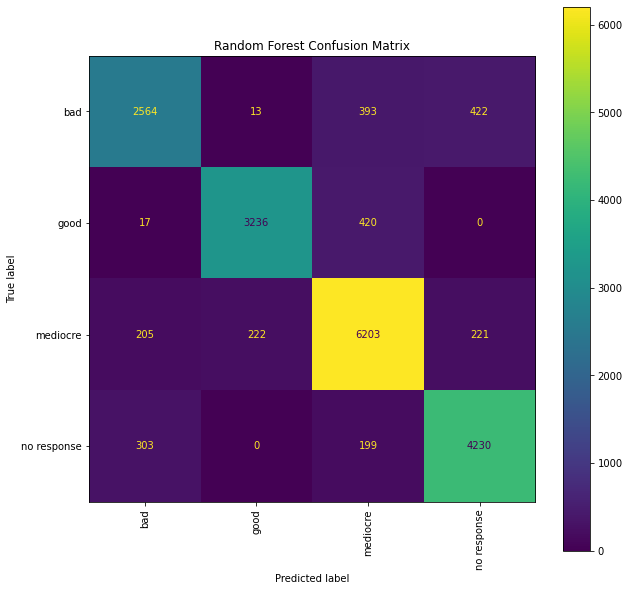

In [79]:
# plot the confusion matrix

labels = pd.Series(y_test.unique()).sort_values()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation = 'vertical')
plt.title('Random Forest Confusion Matrix')

if os.path.exists('../supervised') == False:
    os.makedirs('../supervised')

plt.savefig(f'../supervised/RF_confusion.png', bbox_inches='tight')

In [80]:
# extract the feature importances

rf.feature_importances_

array([0.02732208, 0.06463991, 0.07337582, 0.03033276, 0.1824701 ,
       0.07495722, 0.15041068, 0.00442233, 0.06302876, 0.08729593,
       0.12933863, 0.11240578])

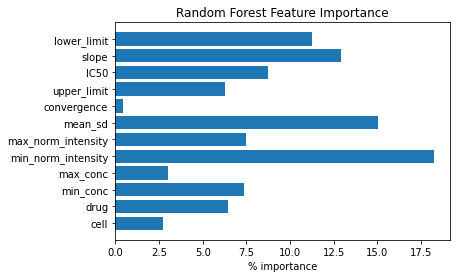

In [81]:
# display the feature importances

plt.barh(X.columns, (rf.feature_importances_)*100)
plt.xlabel('% importance')
plt.title('Random Forest Feature Importance')

if os.path.exists('../supervised') == False:
    os.makedirs('../supervised')

plt.savefig(f'../supervised/RF_features.png', bbox_inches='tight')

#### Train Random Forest model using scaled features

In [185]:
# round 1 of hyperparameter tuning using randomized search cv

n_estimators = [10,50,100,500]
max_depth = [1,5,10,50]
min_samples_split = [2,5]
min_samples_leaf = [1,2,5]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    verbose=1,
    cv=5,
    n_iter=20,
    scoring=f1,
    random_state=0)

rf_random.fit(X_train_scale, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8578543008062602
RandomForestClassifier(max_depth=50, min_samples_split=5)
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50}


In [186]:
# round 2 of hyperparameter tuning using grid search cv

n_estimators = [50,100,200]
max_depth = [25,50,100]
min_samples_split = [3,5,7]
min_samples_leaf = [1,2,3]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train_scale, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.8591083247307184
RandomForestClassifier(max_depth=50, min_samples_split=3)
{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


In [188]:
# round 3 of hyperparameter tuning using grid search cv

n_estimators = [75,100,125]
max_depth = [25,50,75]
min_samples_split = [3,5]
min_samples_leaf = [1]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train_scale, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0.859209363253101
RandomForestClassifier(max_depth=75, min_samples_split=5)
{'max_depth': 75, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [189]:
# round 4 of hyperparameter tuning using grid search cv

n_estimators = [100]
max_depth = [50,75,100]
min_samples_split = [5]
min_samples_leaf = [1]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train_scale, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8583750893205189
RandomForestClassifier(max_depth=50, min_samples_split=5)
{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [190]:
# round 5 of hyperparameter tuning using grid search cv

n_estimators = [100]
max_depth = [25,50,75]
min_samples_split = [5]
min_samples_leaf = [1]

random_grid = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

rf = RandomForestClassifier()

rf_random = GridSearchCV(
    estimator=rf,
    param_grid=random_grid,
    verbose=1,
    cv=5,
    scoring=f1)

rf_random.fit(X_train_scale, y_train)

print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8578105521575617
RandomForestClassifier(max_depth=50, min_samples_split=5)
{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [61]:
# train the model using the best parameters

rf = RandomForestClassifier(n_estimators=100,
                           max_depth=50,
                           min_samples_leaf=1,
                           min_samples_split=5)
rf.fit(X_train_scale, y_train)

RandomForestClassifier(max_depth=50, min_samples_split=5)

In [62]:
# make predictions for y

y_pred = rf.predict(scaler.transform(X_test))

In [63]:
# balanced accuracy score

balanced_accuracy_score(y_test, y_pred)

0.8554363420315054

In [64]:
# f1 score

f1_score(y_test, y_pred, average='weighted')

0.8666449065631767

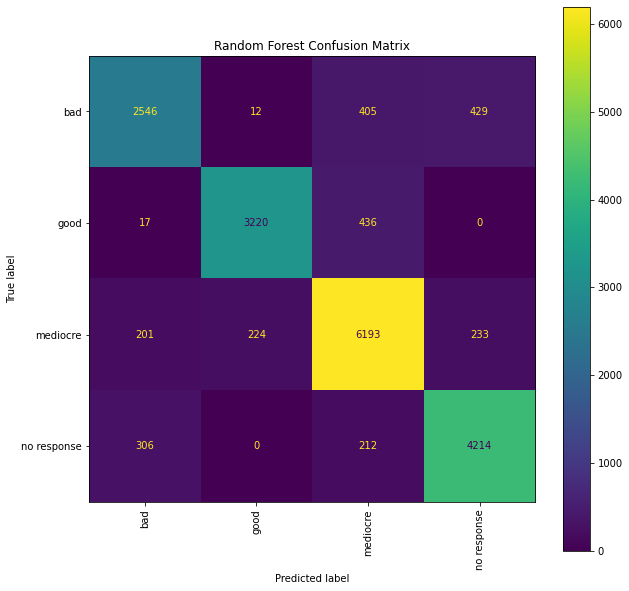

In [73]:
# display the confusion matrix

labels = pd.Series(y_test.unique()).sort_values()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation = 'vertical')
plt.title('Random Forest Confusion Matrix')

if os.path.exists('../supervised') == False:
    os.makedirs('../supervised')

plt.savefig(f'../supervised/RF_Xscaled_confusion.png', bbox_inches='tight')


In [66]:
# extract the feature importances

rf.feature_importances_

array([0.02824906, 0.06945371, 0.07331287, 0.03778245, 0.22156642,
       0.08786617, 0.15787267, 0.00578211, 0.03556927, 0.08808179,
       0.15719174, 0.03727173])

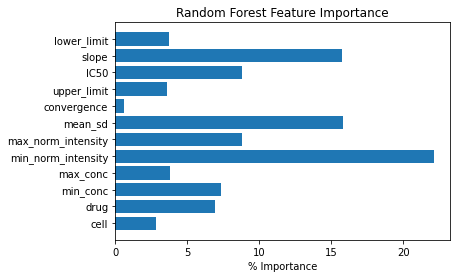

In [72]:
# display the feature importances

plt.barh(X.columns, (rf.feature_importances_)*100)
plt.xlabel('% importance')
plt.title('Random Forest Feature Importance')

if os.path.exists('../supervised') == False:
    os.makedirs('../supervised')

plt.savefig(f'../supervised/RF_Xscaled_features.png', bbox_inches='tight')

In [71]:
# the model using scaled X data performed the best so save it

if os.path.exists('../supervised') == False:
    os.makedirs('../supervised')
    
with open(f"../supervised/RF.pkl", "wb") as f:
        pickle.dump(rf, f)